# Segment Anything Model: automatic mask generation using `transformers` 🤗 library

This notebook demonstrates how to use the Segment Anything Model (SAM) to automatically generate segementation masks on any image. The model was released by Meta AI in the paper [Segment Anything Model](https://ai.facebook.com/research/publications/segment-anything/). The original source code can be found [here](https://github.com/facebookresearch/segment-anything)

The `mask-generation` pipeline, freshly released for SAM, creates a gris of `1024` which are feed in a batch of `points_per_batch` to the model. The examples are inspired from the [original notebook of the authors](https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb).


In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Utility functions

Run the cells below to import the needed utility functions for displaying the masks!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gc

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    del mask
    gc.collect()

def show_masks_on_image(raw_image, masks):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  ax.set_autoscale_on(False)
  for mask in masks:
      show_mask(mask, ax=ax, random_color=True)
  plt.axis("off")
  plt.show()
  del mask
  gc.collect()

## Model loading

Use the `from_pretrained` method on the `SamForMaskGeneration` class to load the model from the Hub! For the sake of this demonstration we will use the `vit-huge` checkpoint.

In [3]:
from transformers import pipeline
generator = pipeline("mask-generation", model="facebook/sam-vit-huge", device=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

### Load the example image

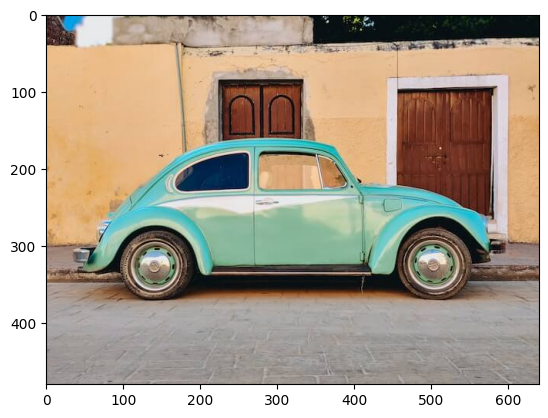

In [4]:
from PIL import Image
import requests

img_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

plt.imshow(raw_image)

# Generate the masks


Let's automatically generate the masks on the image! For that simply pass the raw image into the generator

In [5]:
outputs = generator(raw_image, points_per_batch=64)

The line above you take ~7 seconds on Google Colab 1xNVIDIA-T4, now let's see the resulting segmentation masks.

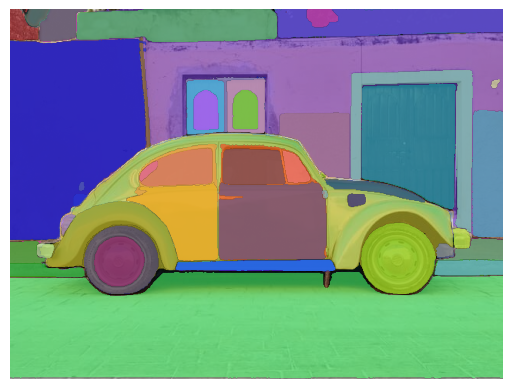

In [6]:
masks = outputs["masks"]
show_masks_on_image(raw_image, masks)

In [18]:
# Mask is a list object
# Note: Each of the 138 masks is a mask denoting the present (True) or absense (False) of an object.
print(len(masks))
print(masks[0])
print(masks[0].sum())

138
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
21948


# Batch of images
You can feed both urls and raw images. Here is an example:

In [7]:
new_image_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/depth-estimation-example.jpg"
outputs = generator([raw_image,new_image_url], points_per_batch=64)

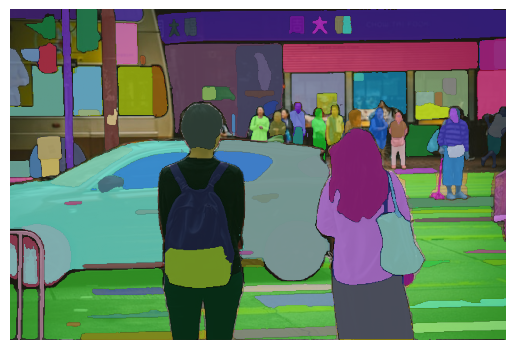

In [8]:
masks = outputs[1]["masks"]
raw_image = Image.open(requests.get(new_image_url, stream=True).raw).convert("RGB")
show_masks_on_image(raw_image, masks)